# [E-12] 프로젝트: 다양한 OCR 모델 비교하기

<br>

---

## ★OCR을 통해 구현하고자 하는 서비스 및 목적★

---

#### 도로 위 이정표 및 표지판을 식별하는 시스템<br>

- 사람이 직접 운전하는 과정을 생각해보자. 사람들은 익숙하지 않은 장소를 주행한다고 할 때, 도로 위 이정표, 표지판을 통해 운전자는 ***경로를 재설정***하거나 ***운전 중 주의사항(과속, 급커브, 동물출몰, 안개구간 등)을 점검***한다. <br><br>**<u>자율주행 차량에서 사람의 눈의 역할을 담당하는 비젼 카메라는 표지판, 이정표의 문자를 인식하는 기술이 필수적이다.</u>** <br><br>***따라서 오늘 살펴볼 서비스는 ocr(광학 문자 인식)기술을 활용한 이정표 및 표지판을 식별하는 시스템이다.***<br><br>

- ***평가기준 : 이정표 및 표지판의 문자를 얼마나 많이 그리고 높은 정확도로 Catch하는지 평가한다.***

<br>

## Step0. 필요한 라이브러리 import하기

---

In [1]:
from matplotlib import pyplot as plt

import cv2
import numpy as np
from PIL import ImageFont, ImageDraw, Image
import os
import itertools  

import keras_ocr
import pytesseract

In [2]:
# 프로젝트 시작 전 주요 라이브러리 버전 살펴보자

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


<br>

## Step1. 검증용 데이터셋 준비

---

- 검증용 데이터셋은 <u>이정표 6장 / 표지판 4장</u> >> ***총 10장의 이미지 데이터***를 준비하였다.

In [3]:
path = os.getenv('HOME')+'/aiffel/_LMS_Exploration/Ex12/Data'
path

'/aiffel/aiffel/_LMS_Exploration/Ex12/Data'

In [4]:
filename = os.listdir(path)
filename = sorted(filename)

In [5]:
if '.ipynb_checkpoints' in filename:
    filename.remove('.ipynb_checkpoints')
filename

['이정표_1.jpg',
 '이정표_2.jpg',
 '이정표_3.jpg',
 '이정표_4.jpg',
 '이정표_5.jpg',
 '이정표_6.jpg',
 '표지판_1.jpg',
 '표지판_2.jpg',
 '표지판_3.jpg',
 '표지판_4.jpg']

In [6]:
filepath = [os.path.join(path, filename[i]) for i in range(10)]
filepath

['/aiffel/aiffel/_LMS_Exploration/Ex12/Data/이정표_1.jpg',
 '/aiffel/aiffel/_LMS_Exploration/Ex12/Data/이정표_2.jpg',
 '/aiffel/aiffel/_LMS_Exploration/Ex12/Data/이정표_3.jpg',
 '/aiffel/aiffel/_LMS_Exploration/Ex12/Data/이정표_4.jpg',
 '/aiffel/aiffel/_LMS_Exploration/Ex12/Data/이정표_5.jpg',
 '/aiffel/aiffel/_LMS_Exploration/Ex12/Data/이정표_6.jpg',
 '/aiffel/aiffel/_LMS_Exploration/Ex12/Data/표지판_1.jpg',
 '/aiffel/aiffel/_LMS_Exploration/Ex12/Data/표지판_2.jpg',
 '/aiffel/aiffel/_LMS_Exploration/Ex12/Data/표지판_3.jpg',
 '/aiffel/aiffel/_LMS_Exploration/Ex12/Data/표지판_4.jpg']

In [7]:
img_data = []

for i in range(10):
    img_data.append(cv2.imread(os.path.join(path, filename[i])))
    

In [8]:
len(img_data)

10

In [9]:
img_data[1].shape

(304, 449, 3)

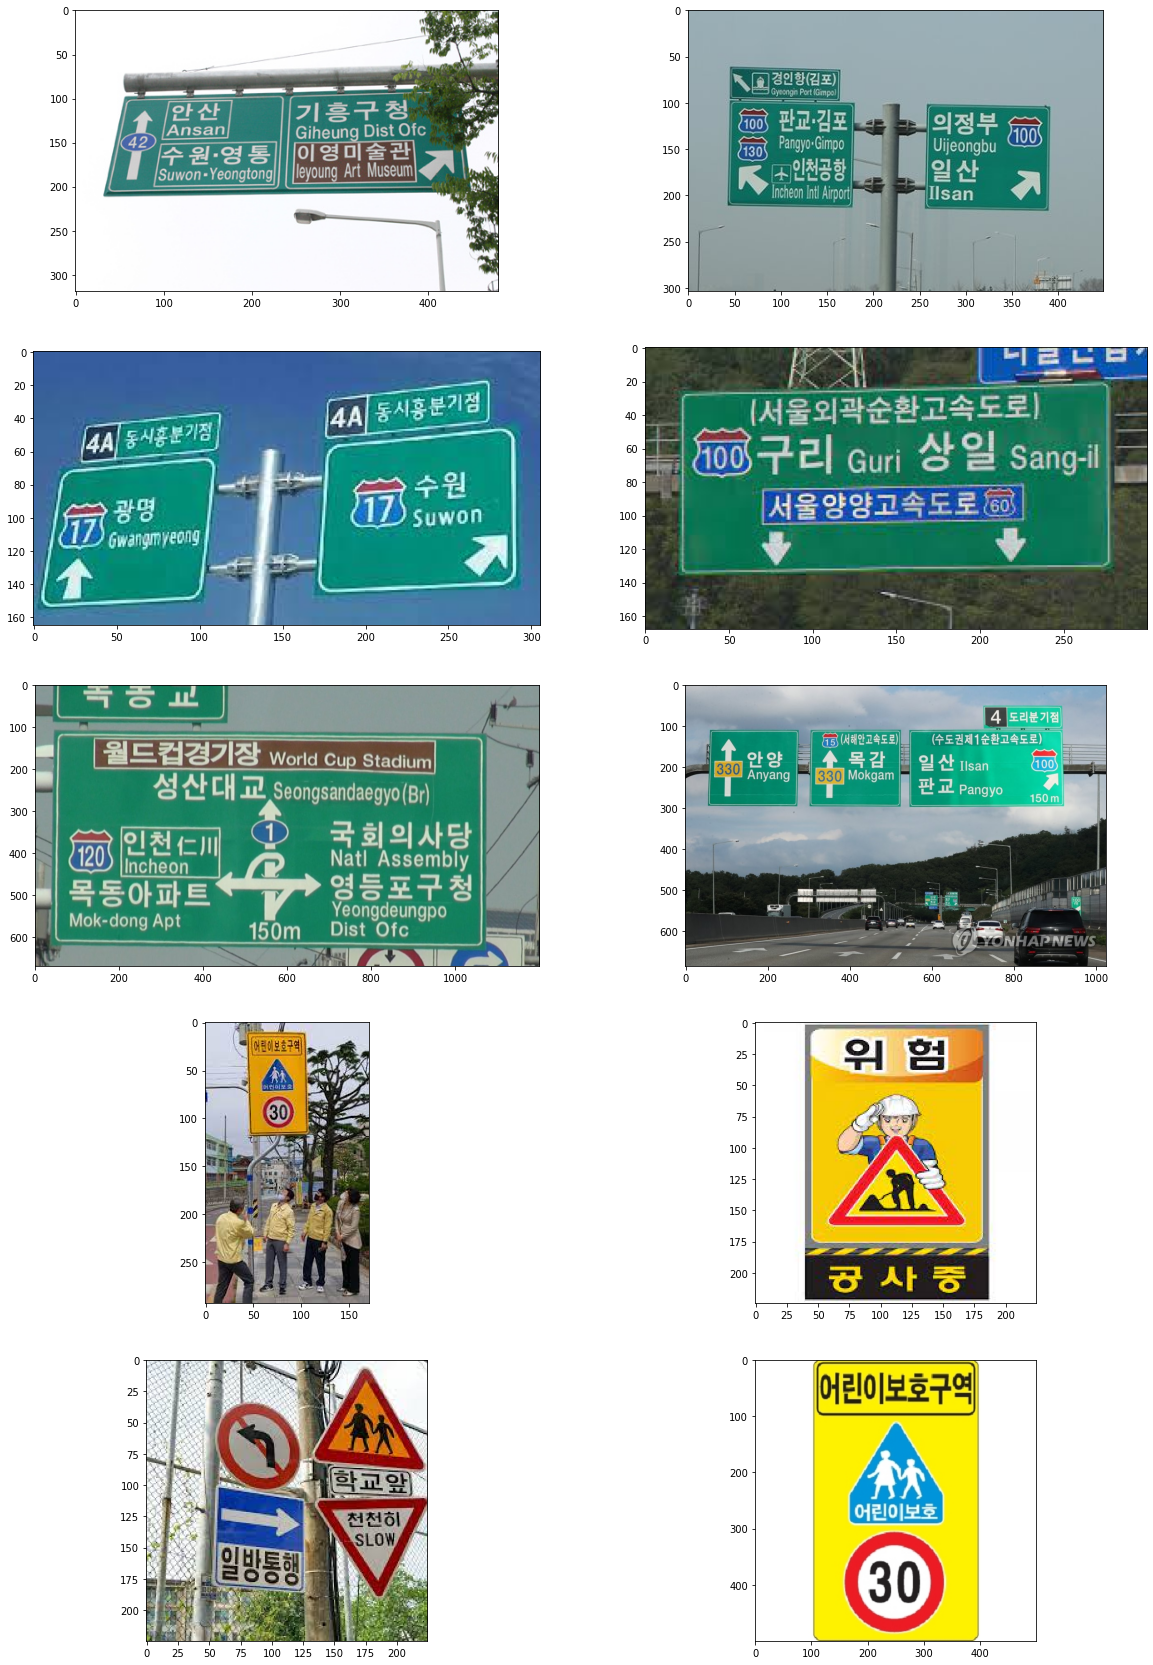

In [10]:
num_rows = 5
num_cols = 2

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 30))
for idx, ax_idx in enumerate(list(itertools.product(range(num_rows), range(num_cols)))):
    axes[ax_idx[0], ax_idx[1]].imshow(cv2.cvtColor(img_data[idx], cv2.COLOR_BGR2RGB))

<br>

## Step2. keras-ocr, Tesseract로 테스트 진행

---

### (1) keras-ocr 써보기

---

In [11]:
%%capture
pip install keras-ocr


***`keras_ocr.pipeline.Pipeline()`는 인식을 위한 파이프라인을 생성하는데 이때 초기화 과정에서 미리 학습된 모델의 가중치(weight)를 불러오게 된다.*** 
- 검줄기와 인식기를 위한 가중치 하나씩을 불러온다.

In [12]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드 받게 된다.
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


<br>

- 만들어둔 파이프라인의 `recognize()`에 이미지를 넣어준다.<br>

In [13]:
images = [keras_ocr.tools.read(f_path) for f_path in filepath]

In [14]:
prediction_groups = [pipeline.recognize([f_path]) for f_path in filepath]

이제 인식된 결과를 pyplot으로 시각화해보자<br>

사용이 매우 간단한데, 내부적으로 `recognize()`는 검출기와 인식기를 두고, 검출기로 바운딩 박스(bounding box, 문자가 있는 영역을 표시한 정보)를 검출한 뒤, 인식기가 각 박스로부터 문자를 인식하는 과정을 거치도록 한다.

In [15]:
type(images[0])

numpy.ndarray

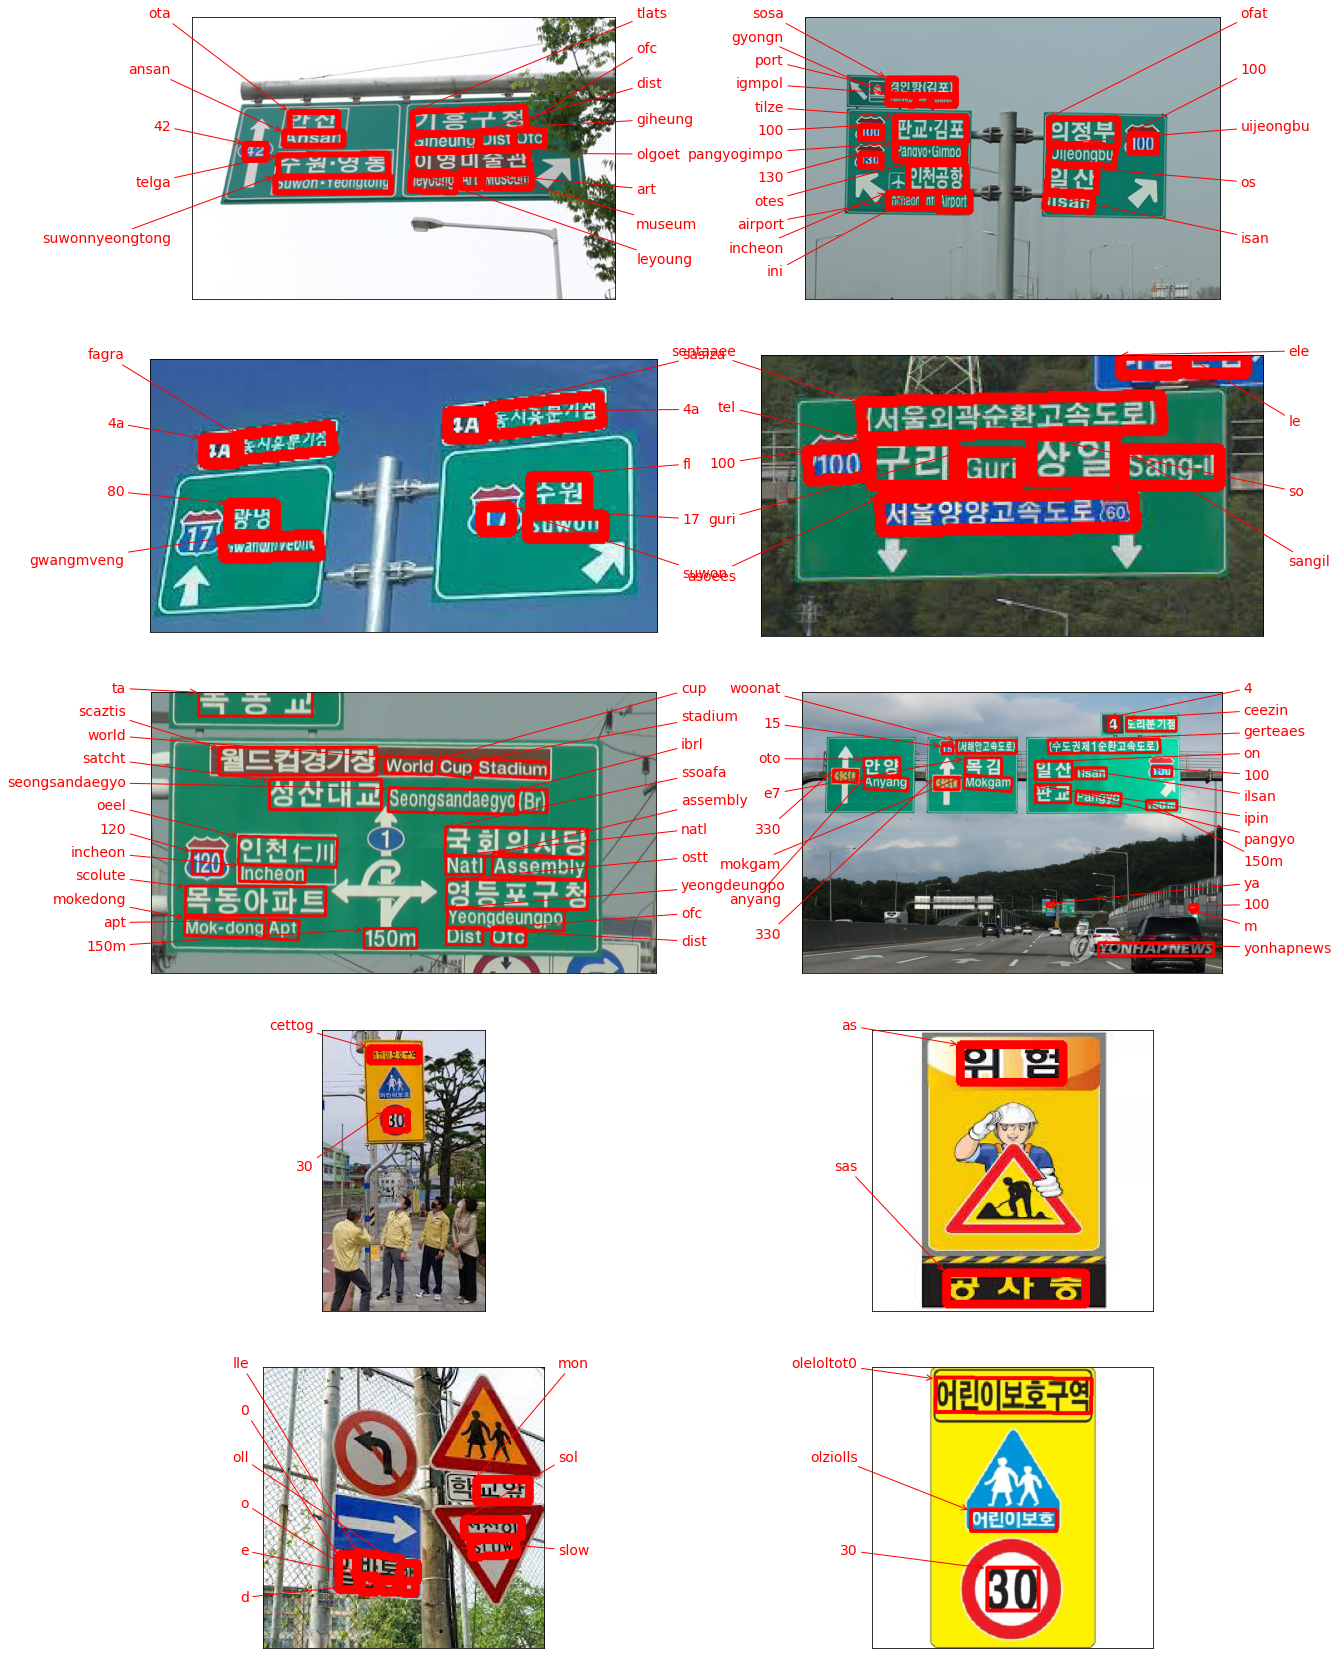

In [17]:
# plot the predictions
num_rows = 5
num_cols = 2

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 30))
for idx, ax_idx in enumerate(list(itertools.product(range(num_rows), range(num_cols)))):
    keras_ocr.tools.drawAnnotations(image=images[idx],
                                   predictions=prediction_groups[idx][0], ax=axes[ax_idx[0], ax_idx[1]])

<br><br>

### (2) 테서랙트(Tesseract) 써보기

---

- 이번에는 테서랙터(Tesseract)라이브러리로 이미지에서 문자를 인식해보자.


- 테서랙트는 구글에서 후원하는 OCR 오픈소스 라이브러리로 현재는 버전 4와 Tesseract.js 등으로 확장되는 등 많은 곳에서 사용된다.


- 버전 4에서는 LSTM이 엔진에 추가되었고 현재 한국어를 포함한 116개 국어를 지원하고 있다.

In [18]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

***테서랙트 설치하기***

---

In [19]:
%%capture
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

***테서랙트 파이썬 Wrapper 설치하기***

---

- `pytesseract`는 OS에 설치된 테서랙트를 파이썬에서 쉽게 사용할 수 있도록 해주는 래퍼 라이브러리(Wrapper Library)<br><br>

In [20]:
%%capture
!pip install pytesseract

In [21]:
!pip list | grep pytesseract

pytesseract                   0.3.8


***(주의) 위 코드에서 lang='kor'로 바꾸면 에러가 발생한다. 테서랙트의 언어팩을 설치해야 정상 동작한다.***

In [22]:
%%capture
!sudo apt install tesseract-ocr-kor

<br>

***테서랙트로 문자 검출하고 이미지 자르기(detection)***

---

- 테서랙트를 사용하면 **한 번에** 이미지 내의 문자 검출과 인식을 할 수 있다. 우리는 OCR이 이뤄지는 전체 과정을 직접 거쳐보기 우해 검출을 먼저해본다.

In [23]:
results = []

custom_oem_psm_config = r'--oem 3 --psm 11'

In [24]:
for i in range(10):
    results.append(pytesseract.image_to_data(img_data[i], lang='kor+eng', config=custom_oem_psm_config, output_type=Output.DICT))

In [25]:
results[0].keys()

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])

In [26]:
def image_text_combine(image, idx):
    for i in range(0, len(image['text'])):
        x = image['left'][i]
        y = image['top'][i]

        w = image['width'][i]
        h = image['height'][i]
        text = image['text'][i]
        conf = int(image['conf'][i])

        if conf > 50:
            text = ''.join([c if ord(c) < 128 else '' for c in text]).strip()
            if (idx == 4) | (idx==5):
                cv2.rectangle(img_data[idx], (x, y), (x+w, y+h), (0, 255, 0), 2)
                cv2.putText(img_data[idx], text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 200), 4)
            else:
                cv2.rectangle(img_data[idx], (x, y), (x+w, y+h), (0, 255, 0), 2)
                cv2.putText(img_data[idx], text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 200), 2)

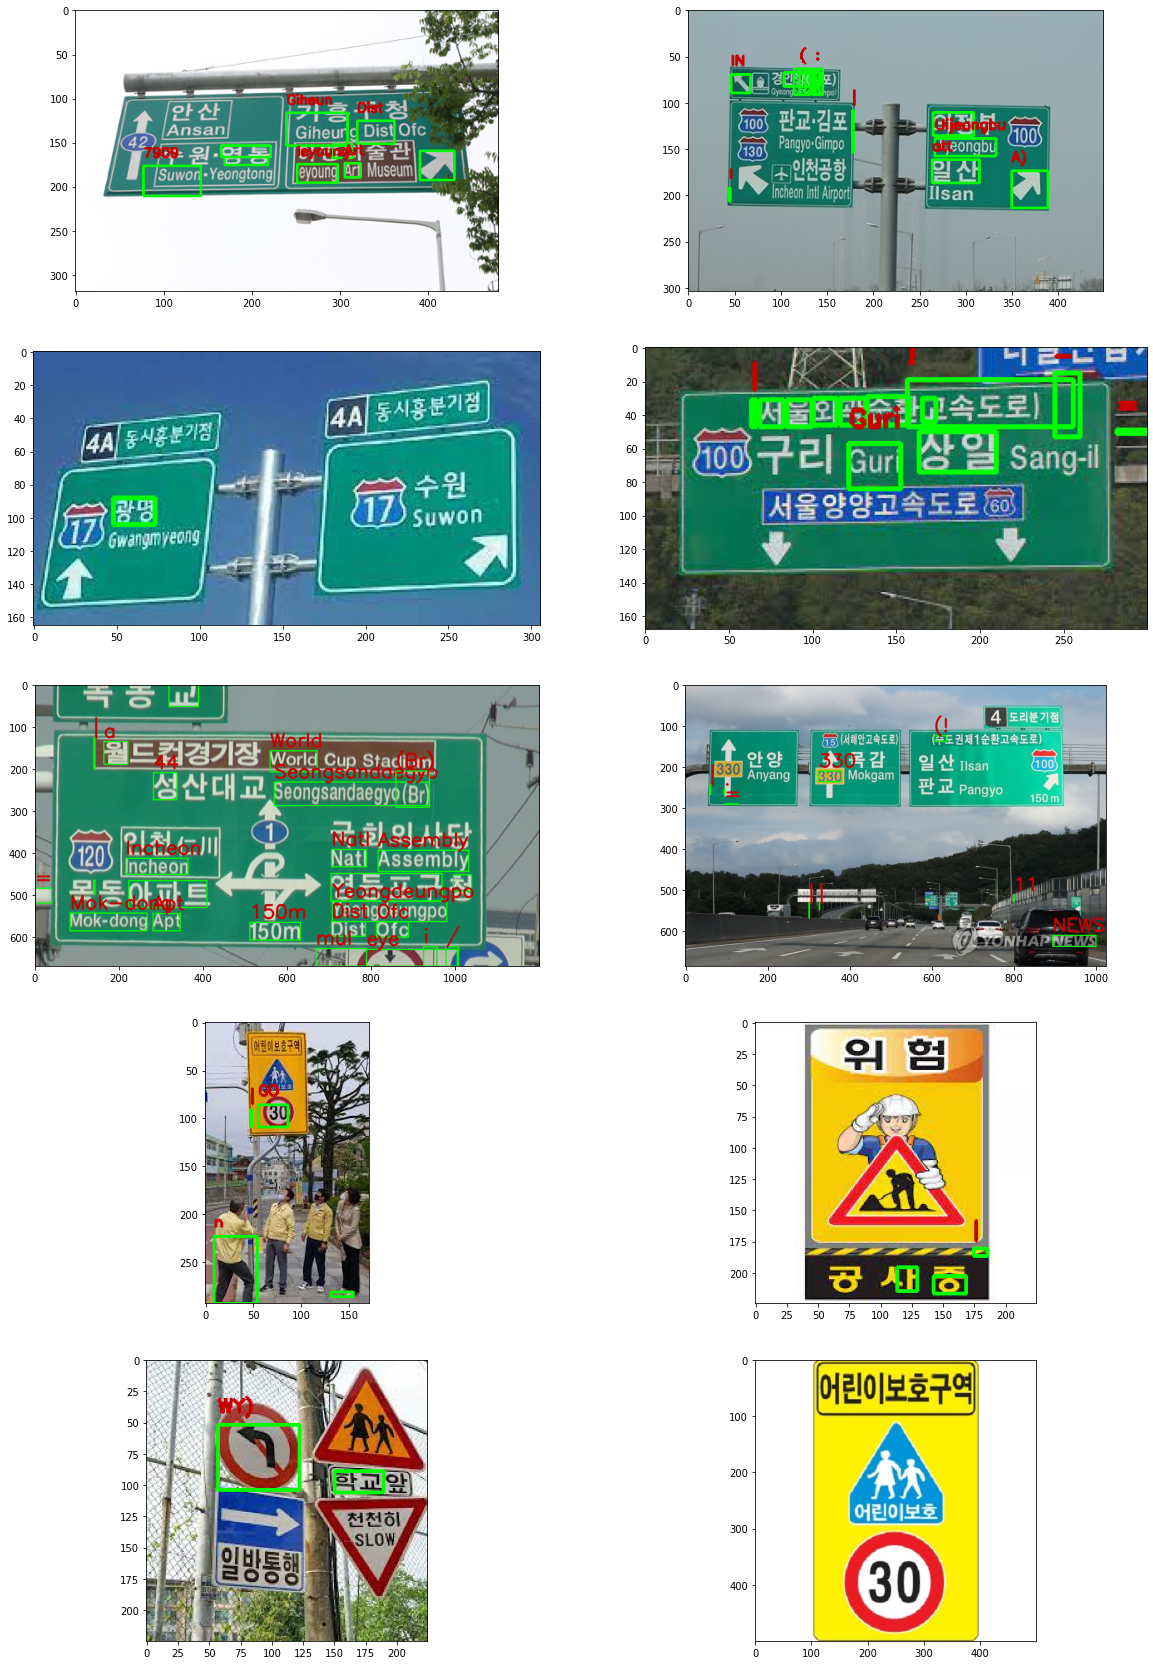

In [27]:
num_rows = 5
num_cols = 2

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 30))
for idx, ax_idx in enumerate(list(itertools.product(range(num_rows), range(num_cols)))):
    image_text_combine(results[idx], idx)
    axes[ax_idx[0], ax_idx[1]].imshow(cv2.cvtColor(img_data[idx], cv2.COLOR_BGR2RGB))

<br><br>

## Step3) 테스트 결과 정리

---

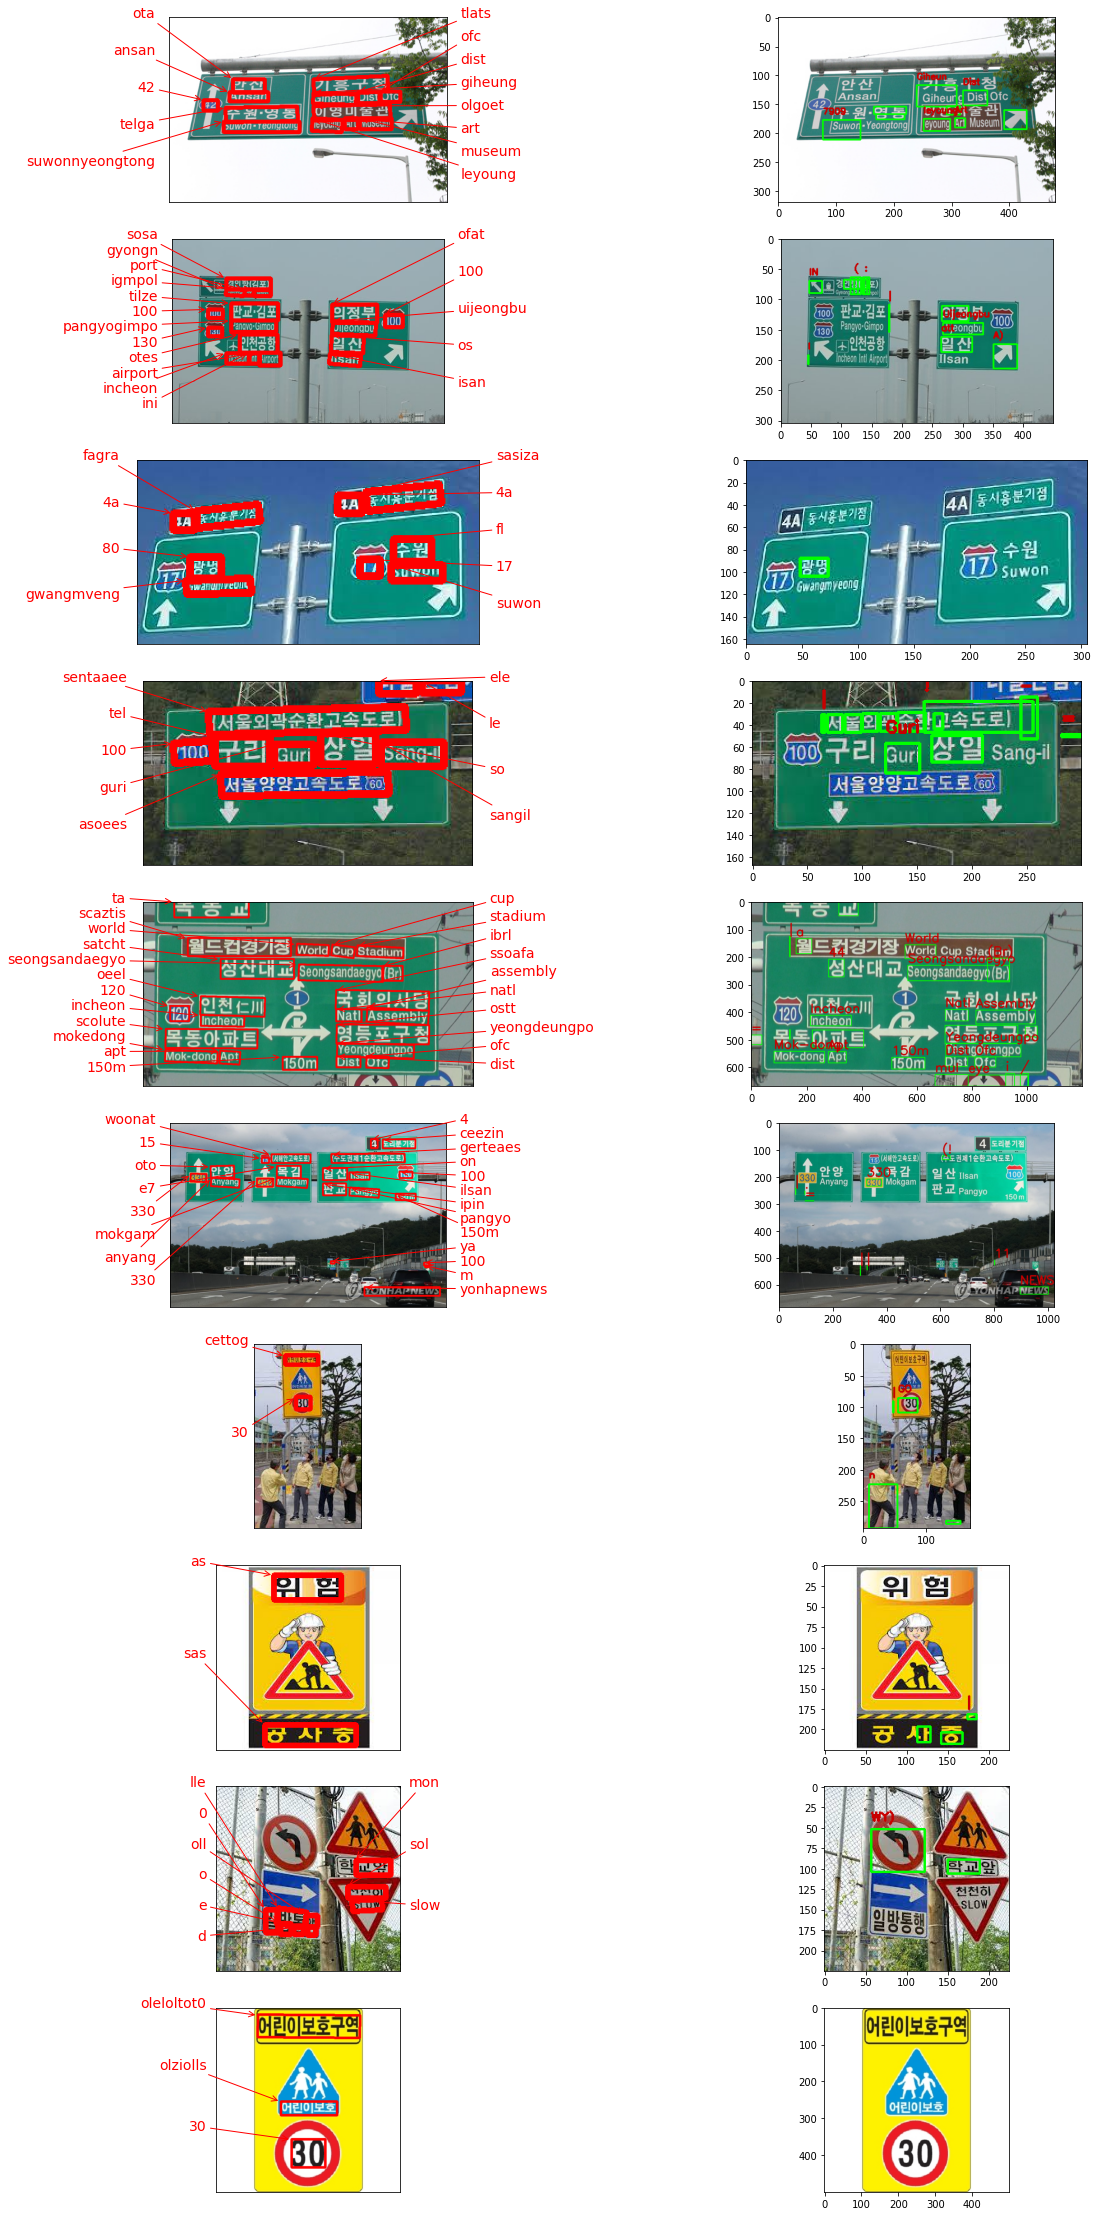

In [50]:
# plot the predictions
num_rows = 10
num_cols = 2


fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 40))
for idx, ax_idx in enumerate(range(num_rows)):
    keras_ocr.tools.drawAnnotations(image=images[idx],
                                   predictions=prediction_groups[idx][0], ax=axes[ax_idx][0])
    image_text_combine(results[idx], idx)
    axes[ax_idx][1].imshow(cv2.cvtColor(img_data[idx], cv2.COLOR_BGR2RGB))

<br>

## 결론
---



- 이번 프로젝트에서는 `keras-ocr`과 `Tesseract-ocr`을 사용하여 도로 위 표지판 및 이정표 식별 성능을 비교해보았다.<br>두 모델을 직접 비교해 보니, keras-ocr이 detection 성능 및 영어 recognition 성능이 더 좋은 것을 확인할 수 있었다. 


- `Tesseract`의 경우 한국어 식별을 하기 위해 언어팩을 설치해 주었으며 `keras-ocr`과 함께 시각화를 통해 결과를 비교하기 위해 opencv의 `rectangle` / `putText` 메서드를 적용하였다. 


- 실제로 노드에서 언급된 것처럼 Keras-ocr은 한국어 인식은 못하였지만, 단어 탐지(detection)은 Tesseract보다 성능이 더 뛰어난 것을 확인할 수 있었다. `keras-ocr`은 영어 및 숫자에 대해서는 좋은 인식률을 보였다. 